## NNSA Geospatial Predictive Analysis + Exploratory Data Analysis
This jupyter notebook provides exploratory data analysis followed by geospatial quantitative analysis of the Fukushima datasets created by NNSA.

### Introduction
This is a continuation of the previous visual qualtative analysis of the NNSA Fukukshima at-sea aerial data. Here, I take the analysis further into quantitative realm which begins by general exploratory data analysis. The cleaned and prepared data is subsequently used to evaluate feature importance and predictive analytics of radioactive trace with respect to time elapsed since the date of the incident.

#### Data Catalogs
- https://catalog.data.gov/dataset/us-doe-nnsa-response-to-2011-fukushima-incident-at-sea-aerial-data

#### Documentations
- https://www.energy.gov/sites/prod/files/2013/10/f3/AMS%20C12%20Sea%20Data%20Dictionary.pdf

### Analytical discussion
During EDA, two of the features were modified for better representation. The Times column was converted into integer form of seconds where it represents time difference since the date of the Fukushima incident on March 11, 2011. The `dist` feature was then created by computing euclidean distance from the coordinate of the power plant. These features were then later fed into random forest regressor, which improved ~10% performance in R-square score metric.

The feature importance was estimated using correlation matrix where `LiveuSec` feature was strongly and inversely correlated with `GCNORM`. This fact was utilized to train base linear regression model and only the `Times` and `LiveuSec` features were fed into the model, which achieved ~90% performance. 

The visual inspection of the twin plot between `dist` and `GCNORM` presented clear distinction between higher `GCNORM` level in land side and relatively lower `GCNORM` level in the ocean. Taking this account, different machine learning models were trained and optimized using exhaustive grid search where linear regression model performed best.

Further feature engineering was experimented by feature selection and column-wise normalization. While linear regression model did not improve any further with use of other features outside of `LiveuSec`, random forest model significantly improved its performance when more features were added. Further improvement was made after column-wise normalization was done. This optimized model performed almost as well as the linear regression model. The visual inspection of last 300 samples of this time-series data shows good extrapolation at the end of the dataset.

### Import packages

In [1]:
!python -V

Python 3.8.13


In [2]:
from nnsa.dataLoader import dataLoader
from nnsa.visualization import render_map

#### Load datasets from dataLoader class
dataLoader class loads files directly from http request, stores and unzip kmz file locally, and parse kml into geopandas dataframe

In [3]:
# instantiation of the NNSA dataLoader class
dl = dataLoader()

In [4]:
# invoking `load_data` method (only loading the at-sea dataset)
dl.load_data(preprocess=True, only_load=[0])

Preprocessing skipped for [fuku-iodine]
Preprocessing skipped for [fuku-nnsa-response]


In [5]:
# 3 datasets are loaded
dl.data.keys()

dict_keys(['fuku-at-sea'])

### Exploratory Data Analysis of the Fukushima at-sea aerial dataset
The data is parsed from unconventional form of unstructured KMZ data into a geopanda dataframe. The data is analyzed and inspected for statistical analysis and for machine learning based predictive analytics

In [6]:
dl.data['fuku-at-sea']

,Time,Latitude,Longitude,ALT_HAE,AGL,LiveuSec,GC,GCNORM
0,2011-04-05 02:11:00,37.762307,140.959459,243.557,163.28,997353.0,20364.0,20418.05
1,2011-04-05 02:11:00,37.761519,140.959672,244.135,151.00,997066.0,21513.0,21576.30
2,2011-04-05 02:11:00,37.760735,140.959890,243.184,149.50,997057.0,21180.0,21242.52
3,2011-04-05 02:11:00,37.759945,140.960111,242.065,161.04,997843.0,19272.0,19313.66
4,2011-04-05 02:11:00,37.759161,140.960330,242.198,171.78,997653.0,16321.0,16359.40
...,...,...,...,...,...,...,...,...
4524,2011-04-05 03:28:00,37.452455,141.083456,272.289,232.04,999534.0,3284.0,3285.53
4525,2011-04-05 03:28:00,37.451668,141.083711,281.316,241.08,999484.0,3222.0,3223.66
4526,2011-04-05 03:28:00,37.450898,141.084009,290.964,250.73,999583.0,3120.0,3121.30
4527,2011-04-05 03:28:00,37.450898,141.084009,290.964,250.73,999536.0,3151.0,3152.46


In [7]:
# NNSA dataLoader class calls preprocessor method to change data types of each column
dl.data['fuku-at-sea'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4529 entries, 0 to 4528
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Time       4529 non-null   datetime64[ns]
 1   Latitude   4529 non-null   float64       
 2   Longitude  4529 non-null   float64       
 3   ALT_HAE    4529 non-null   float64       
 4   AGL        4529 non-null   float64       
 5   LiveuSec   4529 non-null   float64       
 6   GC         4529 non-null   float64       
 7   GCNORM     4529 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 283.2 KB


#### Datetime conversion for regression
Datetime dtype is not a numeric object, thus the column needs to be either integer or float. Here I am using delta time from the date of incident as a temporal representation

In [8]:
from datetime import datetime

In [9]:
# The incident occurred on March 11, 2011
dl.data['fuku-at-sea']['Time'] = dl.data['fuku-at-sea'].apply(lambda x: (x['Time'] - datetime(2011, 3, 11)).seconds, axis=1)
dl.data['fuku-at-sea']['Time'] = dl.data['fuku-at-sea']['Time'].astype(int) #the dtype is appropriately changed to the integer

In [10]:
dl.data['fuku-at-sea'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4529 entries, 0 to 4528
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time       4529 non-null   int32  
 1   Latitude   4529 non-null   float64
 2   Longitude  4529 non-null   float64
 3   ALT_HAE    4529 non-null   float64
 4   AGL        4529 non-null   float64
 5   LiveuSec   4529 non-null   float64
 6   GC         4529 non-null   float64
 7   GCNORM     4529 non-null   float64
dtypes: float64(7), int32(1)
memory usage: 265.5 KB


In [11]:
# sanity check to make sure the conversion is done properly
dl.data['fuku-at-sea'].Time.unique()

array([ 7860,  7920,  7980,  8040,  8100,  8160,  8220,  8280,  8340,
        8400,  8460,  8520,  8580,  8640,  8700,  8760,  8820,  8880,
        8940,  9000,  9060,  9120,  9180,  9240,  9300,  9360,  9420,
        9480,  9540,  9600,  9660,  9720,  9780,  9840,  9900,  9960,
       10020, 10080, 10140, 10200, 10260, 10320, 10380, 10440, 10500,
       10560, 10620, 10680, 10740, 10800, 10860, 10920, 10980, 11040,
       11100, 11160, 11220, 11280, 11340, 11400, 11460, 11520, 11580,
       11640, 11700, 11760, 11820, 11880, 11940, 12000, 12060, 12120,
       12180, 12240, 12300, 12360, 12420, 12480])

#### Inspect correlation matrix of the features
Notice here that `NumDet` is dropped from the dataframe as the variable contained insignificant values, namely the column had a single value

In [12]:
dl.data['fuku-at-sea'].corr()

,Time,Latitude,Longitude,ALT_HAE,AGL,LiveuSec,GC,GCNORM
Time,1.000000,-0.039164,0.339461,0.040908,0.188574,0.326914,-0.325904,-0.324702
Latitude,-0.039164,1.000000,-0.307889,-0.111831,-0.148930,0.229070,-0.229567,-0.228916
Longitude,0.339461,-0.307889,1.000000,-0.137870,0.048703,0.422847,-0.419876,-0.417847
ALT_HAE,0.040908,-0.111831,-0.137870,1.000000,0.931742,-0.227050,0.234697,0.234599
AGL,0.188574,-0.148930,0.048703,0.931742,1.000000,0.012495,-0.002808,-0.002276
LiveuSec,0.326914,0.229070,0.422847,-0.227050,0.012495,1.000000,-0.990164,-0.990040
GC,-0.325904,-0.229567,-0.419876,0.234697,-0.002808,-0.990164,1.000000,0.999983
GCNORM,-0.324702,-0.228916,-0.417847,0.234599,-0.002276,-0.990040,0.999983,1.000000


Here the visual inspection of the correlation matrix reveals meaningful information about correlation between features

<AxesSubplot:>

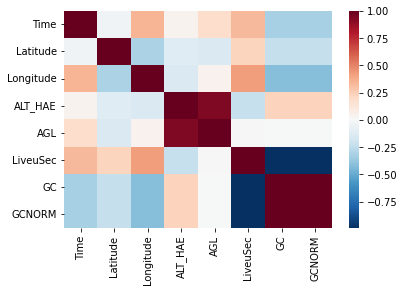

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(dl.data['fuku-at-sea'].corr(), cmap='RdBu_r')

We can deduce here that `AGL` is not correlated with most of the other features whereas `GC` practically follows the same trend as our y-label `GCNORM`, which makes sense as the y-label is the normalized form of the `GC`. Thus, for our machine learning model, these two variables will be removed. Another notable feature to recognize is `LiveuSec` which has a strong inverse coorelation with `GCNORM`.

#### Visualize the distance and y-label via feature engineering
To quantitatively look at the trend between location and radiation, I created a new feature called `dist` which is simply the euclidean distance of the coordinate of each measurement from the power plant location.

In [14]:
from sklearn.metrics.pairwise import euclidean_distances

ref_coordinate = (37.4218, 141.0337) #this is the coordinate of the power plant
dl.data['fuku-at-sea']['dist'] = euclidean_distances(dl.data['fuku-at-sea'][['Latitude', 'Longitude']].to_numpy(), [ref_coordinate])

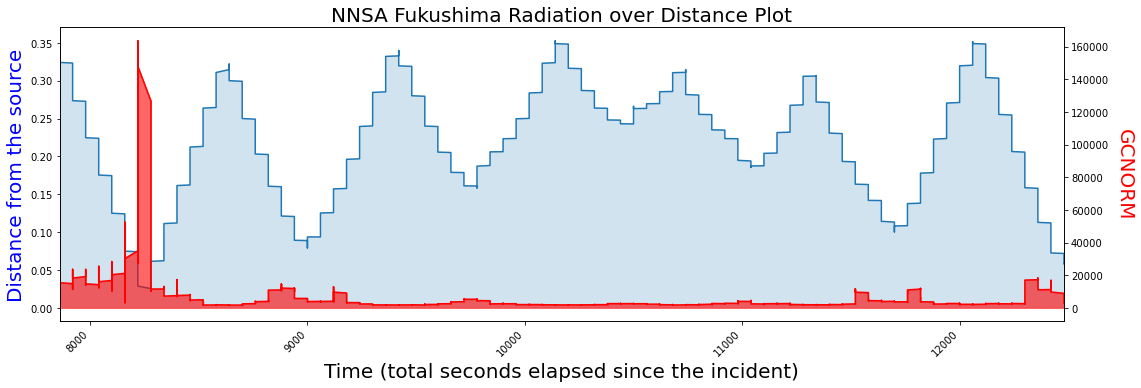

In [15]:
fig, ax = plt.subplots(figsize=(18,6))

ax2 = ax.twinx()

ax.plot(dl.data['fuku-at-sea']['Time'], dl.data['fuku-at-sea']['dist'])
ax.fill_between(dl.data['fuku-at-sea']['Time'], dl.data['fuku-at-sea']['dist'], alpha=0.2)

ax2.plot(dl.data['fuku-at-sea']['Time'], dl.data['fuku-at-sea']['GCNORM'], color='red')
ax2.fill_between(dl.data['fuku-at-sea']['Time'], dl.data['fuku-at-sea']['GCNORM'], alpha=0.6, color='red')

ax.set_ylabel('Distance from the source', fontsize=20, color='blue')
ax.set_xlabel('Time (total seconds elapsed since the incident)', fontsize=20)
ax.set_title('NNSA Fukushima Radiation over Distance Plot', fontsize=20)
ax.set_xlim(dl.data['fuku-at-sea']['Time'].min(), dl.data['fuku-at-sea']['Time'].max())

ax2.set_ylabel('GCNORM', rotation=270, fontsize=20, color='red')
ax2.yaxis.set_label_coords(1.07,0.5);

fig.autofmt_xdate(rotation=45)

Notice that the radiation was captured at sea soon after aircraft sweeped the power plant where the radiation is the highest in the plot.

## Predictive analytics using machine learning method
Here I am extrapolative predictive analysis of the last N number of samples using feature engineering and optimized machine learning algorithms. Mainly, I am testing and optimizing generalized linear regressor, tree-based ensemble model, gradient boosting model, neural network via exhaustive grid searching. The performance of each regressor is measured using R-squared metric.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter('ignore')

c:\ProgramData\Anaconda3\envs\main\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [17]:
new_X = dl.data['fuku-at-sea'].drop(['AGL','GC','GCNORM','dist'], axis=1)
new_y = dl.data['fuku-at-sea']['GCNORM']
new_X.shape, new_y.shape

((4529, 5), (4529,))

In [18]:
new_X.head()

,Time,Latitude,Longitude,ALT_HAE,LiveuSec
0,7860,37.762307,140.959459,243.557,997353.0
1,7860,37.761519,140.959672,244.135,997066.0
2,7860,37.760735,140.959890,243.184,997057.0
3,7860,37.759945,140.960111,242.065,997843.0
4,7860,37.759161,140.960330,242.198,997653.0


In [19]:
def train_test_split(X, y, ts):
    '''non-randomized train test split for time-series'''
    
    train_X, train_y = X[:-ts], y[:-ts]
    test_X, test_y = X[-ts:], y[-ts:]

    print(f'Train Shape: {train_X.shape} | Test Shape: {test_X.shape}')

    return train_X, test_X, train_y, test_y

In [20]:
def draw_prediction_plot(X, y, test_X, y_pred, dlim):
    fig, ax = plt.subplots(figsize=(18,6))

    ax2 = ax.twinx()

    ax2.plot(X[-dlim:], y[-dlim:], color='red', label='Original')
    ax2.plot(test_X, y_pred, color='blue', label='Prediction', ls='--')
    ax2.fill_between(X[-dlim:], y[-dlim:], alpha=0.3, color='red')

    ax.set_ylabel('Distance from the source', fontsize=20, color='blue')
    ax.set_xlabel('Time (total seconds elapsed since the incident)', fontsize=20)
    ax.set_title('NNSA Fukushima Radiation over Distance Plot', fontsize=20)
    ax.set_xlim(X[-dlim:].min(), X[-dlim:].max())

    ax2.set_ylabel('GCNORM', rotation=270, fontsize=20, color='red')
    ax2.yaxis.set_label_coords(1.07,0.5);
    ax2.legend()

    fig.autofmt_xdate(rotation=45)
    # fig.show()

In [21]:
def regressor_score(model, param=None):
    if param:
        clf = GridSearchCV(model, param_grid=param).fit(train_X, train_y)
        y_pred = clf.predict(test_X)
        print(f'Best Parameters: {clf.best_params_}')
    else:
        y_pred = model.fit(train_X, train_y).predict(test_X)

    print(f'R^2 Score: {r2_score(y_true=test_y, y_pred=y_pred)}')

    return y_pred

In [22]:
train_X, test_X, train_y, test_y = train_test_split(X=new_X, y=new_y, ts=300)

Train Shape: (4229, 5) | Test Shape: (300, 5)


#### Tree-based ensemble model

In [23]:
param = {
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [100, 200, 500]
}
y_pred = regressor_score(model=RandomForestRegressor(), param=param)
# y_pred = regressor_score(model=RandomForestRegressor(), param=None)

Best Parameters: {'max_features': 'sqrt', 'n_estimators': 100}
R^2 Score: 0.7349366489303596


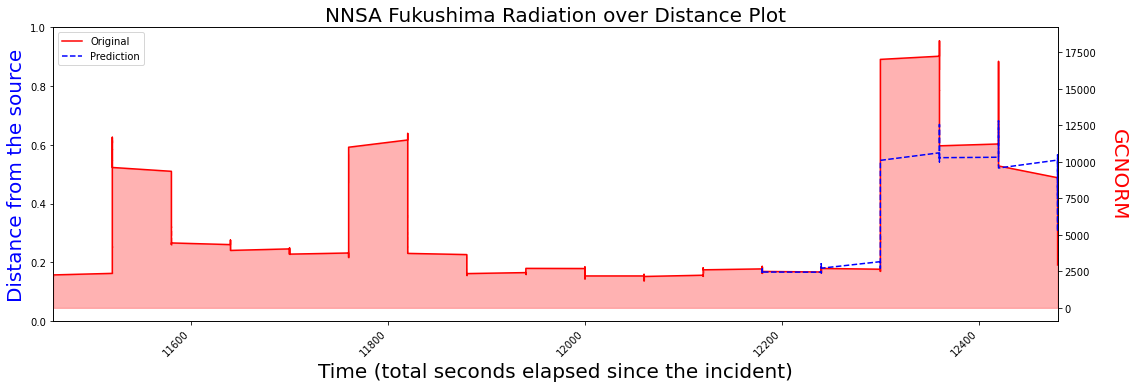

In [24]:
draw_prediction_plot(new_X['Time'], new_y, test_X['Time'], y_pred, dlim=1000)

#### Base linear regression model
Surprisingly outperforms other "state-of-the-art" models in terms of R-squared metric

In [25]:
y_pred = regressor_score(model=LinearRegression())

R^2 Score: 0.9051109051605595


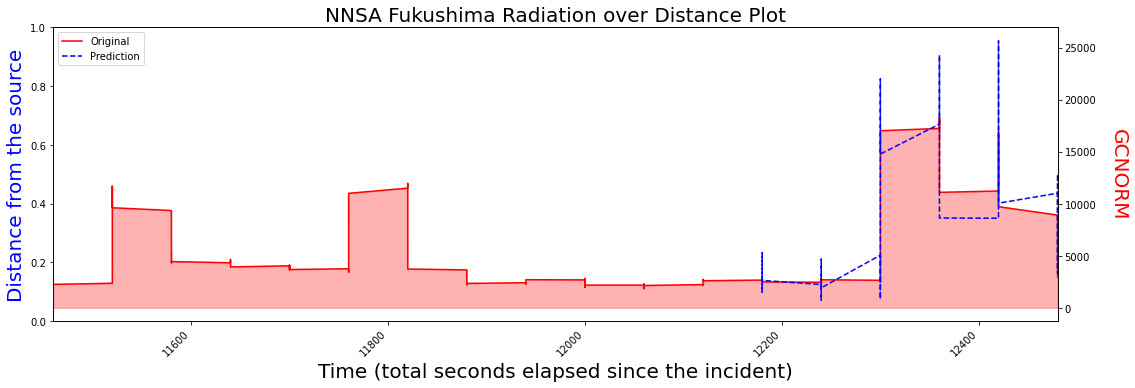

In [26]:
draw_prediction_plot(new_X['Time'], new_y, test_X['Time'], y_pred, dlim=1000)

#### Neural network model
Multilayer perceptron of varing size and complexity failed to learn this task

In [27]:
param = {
    'hidden_layer_sizes': [100, 200, 500],
    'alpha': [0.01, 0.001, 0.0001],
    'learning_rate_init': [0.01, 0.001, 0.0001]
}
y_pred = regressor_score(model=MLPRegressor(), param=param)
# y_pred = regressor_score(model=MLPRegressor(), param=None)

Best Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.001}
R^2 Score: -2.2541508210864967


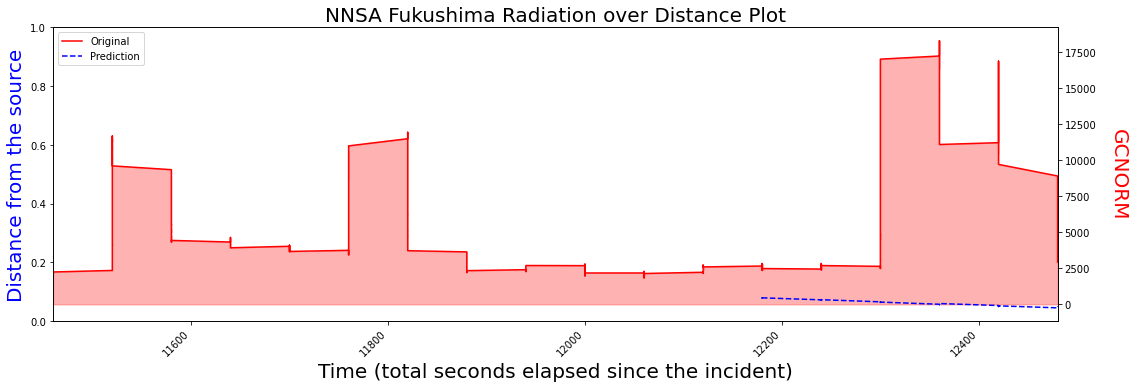

In [28]:
draw_prediction_plot(new_X['Time'], new_y, test_X['Time'], y_pred, dlim=1000)

#### Gradient boosting model
Extreme gradient boosting regressor model performed similarly as the random forest

In [29]:
param = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.001, 0.0001]
}
y_pred = regressor_score(model=XGBRegressor(), param=param)
# y_pred = regressor_score(model=XGBRegressor(), param=None)

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 200}
R^2 Score: 0.7484000602983085


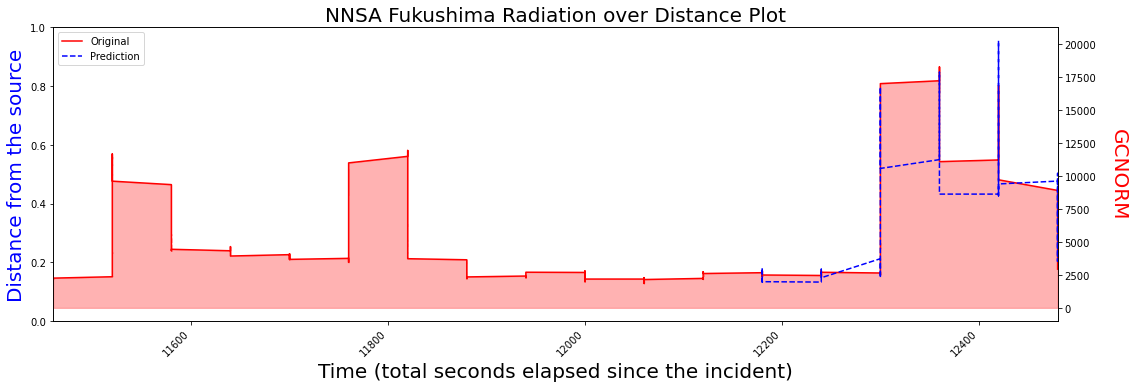

In [30]:
draw_prediction_plot(new_X['Time'], new_y, test_X['Time'], y_pred, dlim=1000)

### Predictive improvement by feature engineering
This time I attempt to predict `dist`, the euclidean distance from the power plant given rest of the features. In this case, I show improvement of prediction score, namely R-squared, solely by the addition of 

In [31]:
from sklearn.preprocessing import normalize, StandardScaler

In [32]:
new_X = dl.data['fuku-at-sea'].drop(['GC','GCNORM'], axis=1)
new_X = new_X.drop(['Latitude','Longitude','ALT_HAE', 'AGL','dist'], axis=1)
new_y = dl.data['fuku-at-sea']['GCNORM']

new_X.shape, new_y.shape

((4529, 2), (4529,))

In [33]:
new_X.head()

,Time,LiveuSec
0,7860,997353.0
1,7860,997066.0
2,7860,997057.0
3,7860,997843.0
4,7860,997653.0


In [34]:
train_X, test_X, train_y, test_y = train_test_split(X=new_X, y=new_y, ts=300)

Train Shape: (4229, 2) | Test Shape: (300, 2)


In [35]:
y_pred = regressor_score(model=LinearRegression())

R^2 Score: 0.9062095700203506


As indicative from the correlation matrix, the highest correlation was observed between `LiveuSec` and `GCNORM`. Even without other features, simple linear regression model can acheive ~0.90 from R-square metric. On the other hand, random forest is not able to achieve such high R-square score just with two features

In [36]:
y_pred = regressor_score(model=RandomForestRegressor())

R^2 Score: 0.8007581394191977


As a form of feature engineering, I added back all the other features that were not useful at all for the linear regressor

In [37]:
new_X = dl.data['fuku-at-sea'].drop(['GC','GCNORM'], axis=1)
new_X = new_X.drop(['dist'], axis=1)
new_y = dl.data['fuku-at-sea']['GCNORM']

train_X, test_X, train_y, test_y = train_test_split(X=new_X, y=new_y, ts=300)

y_pred = regressor_score(model=RandomForestRegressor())

Train Shape: (4229, 6) | Test Shape: (300, 6)
R^2 Score: 0.8788230704943302


Then I additionally added `dist` as a new feature in addition to the other features that were added

In [38]:
new_X = dl.data['fuku-at-sea'].drop(['GC','GCNORM'], axis=1)
# new_X = new_X.drop(['Latitude','Longitude','ALT_HAE', 'AGL','dist'], axis=1)
new_y = dl.data['fuku-at-sea']['GCNORM']

train_X, test_X, train_y, test_y = train_test_split(X=new_X, y=new_y, ts=300)

y_pred = regressor_score(model=RandomForestRegressor())

Train Shape: (4229, 7) | Test Shape: (300, 7)
R^2 Score: 0.875565474641027


Finally, I rescaled the range of feature values by normalizing each feature separately

In [39]:
for col in new_X.iloc[:, 1:]:
    new_X[col] = normalize([new_X[col]])[0]

train_X, test_X, train_y, test_y = train_test_split(X=new_X, y=new_y, ts=300)

y_pred = regressor_score(model=RandomForestRegressor())

Train Shape: (4229, 7) | Test Shape: (300, 7)
R^2 Score: 0.8932990948893575


Conclusively, each step of the feature engineering improved R-square score more and more

### End of the notebook